<a target="_blank" href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/rapids-pip-colab-template.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Install RAPIDS into Colab"/>
</a>

# RAPIDS cuDF is now already on your Colab instance!
RAPIDS cuDF is preinstalled on Google Colab and instantly accelerates Pandas with zero code changes. [You can quickly get started with our tutorial notebook](https://nvda.ws/rapids-cudf). This notebook template is for users who want to utilize the full suite of the RAPIDS libraries for their workflows on Colab.  

# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

You can check the output of `!nvidia-smi` to check which GPU you have.  Please uncomment the cell below if you'd like to do that.  Currently, RAPIDS runs on all available Colab GPU instances.

In [1]:
!nvidia-smi

Fri Apr 11 04:40:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Setup:
This set up script:

1. Checks to make sure that the GPU is RAPIDS compatible
1. Pip Installs the RAPIDS' libraries, which are:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuxFilter
  1. cuCIM
  1. xgboost

# Controlling Which RAPIDS Version is Installed
This line in the cell below, `!python rapidsai-csp-utils/colab/pip-install.py`, kicks off the RAPIDS installation script.  You can control the RAPIDS version installed by adding either `latest`, `nightlies` or the default/blank option.  Example:

`!python rapidsai-csp-utils/colab/pip-install.py <option>`

You can now tell the script to install:
1. **RAPIDS + Colab Default Version**, by leaving the install script option blank (or giving an invalid option), adds the rest of the RAPIDS libraries to the RAPIDS cuDF library preinstalled on Colab.  **This is the default and recommended version.**  Example: `!python rapidsai-csp-utils/colab/pip-install.py`
1. **Latest known working RAPIDS stable version**, by using the option `latest` upgrades all RAPIDS labraries to the latest working RAPIDS stable version.  Usually early access for future RAPIDS+Colab functionality - some functionality may not work, but can be same as the default version. Example: `!python rapidsai-csp-utils/colab/pip-install.py latest`
1. **the current nightlies version**, by using the option, `nightlies`, installs current RAPIDS nightlies version.  For RAPIDS Developer use - **not recommended/untested**.  Example: `!python rapidsai-csp-utils/colab/pip-install.py nightlies`


**This will complete in about 5-6 minutes**

In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 587, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 587 (delta 122), reused 85 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (587/587), 193.00 KiB | 1003.00 KiB/s, done.
Resolving deltas: 100% (296/296), done.
Installing RAPIDS remaining 25.02 libraries
error: a value is required for '--prerelease <PRERELEASE>' but none was supplied
  [possible values: disallow, allow, if-necessary, explicit, if-necessary-or-explicit]

For more information, try '--help'.

        ***********************************************************************
        The pip install of RAPIDS is complete.

        Please do not run any further installation from the conda based installation methods, as they may cause issues!

        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshoot

# RAPIDS is now installed on Colab.  
You can copy your code into the cells below or use the below to validate your RAPIDS installation and version.  
# Enjoy!

In [3]:
from cuml.ensemble import RandomForestClassifier as cuRF
from sklearn.metrics import accuracy_score
import cuml
from cupy import asnumpy
from joblib import dump, load
import time

def random_forest_cuml(x_train, x_test, y_train, y_test, n_estimators, max_depth):
    st = time.time()
    model = cuRF( max_depth = max_depth,
                  n_estimators = n_estimators,
                  random_state  = 0 )

    trained_RF = model.fit ( X_train, y_train )

    predictions = model.predict ( X_test )

    cu_score = cuml.metrics.accuracy_score( y_test, predictions )
    sk_score = accuracy_score( asnumpy( y_test ), asnumpy( predictions ) )

    # print( " cuml accuracy: ", cu_score )
    # print( " sklearn accuracy : ", sk_score )
    diff = time.time() - st
    return diff, sk_score

In [4]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score

def random_forest_sklearn(x_train, x_test, y_train, y_test, n_estimators, max_depth):
    st = time.time()
    model = RF( max_depth = max_depth,
                  n_estimators = n_estimators,
                  random_state  = 0 )

    trained_RF = model.fit ( X_train, y_train )

    predictions = model.predict ( X_test )

    cu_score = cuml.metrics.accuracy_score( y_test, predictions )
    sk_score = accuracy_score( y_test, predictions )

    # print( " cuml accuracy: ", cu_score )
    # print( " sklearn accuracy : ", sk_score )
    diff = time.time() - st
    return diff, sk_score

100%|██████████| 6/6 [01:25<00:00, 14.32s/it]


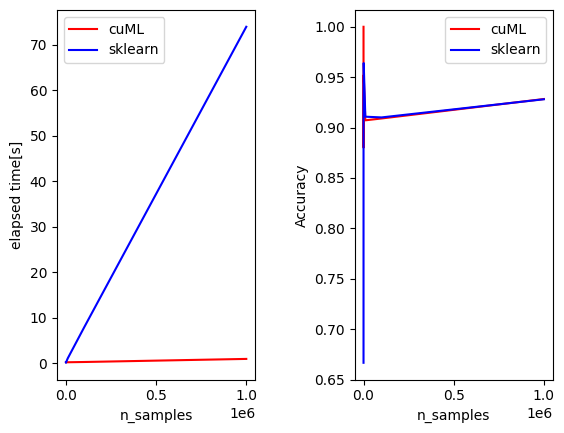

In [7]:
from sklearn.datasets import make_classification
from cuml.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
# synthetic dataset dimensions
n_samples = 1000
n_features = 10
n_classes = 2

# random forest depth and size
n_estimators = 25
max_depth = 10

elapsed_times = {"cuml": [], "sklearn": []}
accuracies = {"cuml": [], "sklearn": []}
n_samples_list = []
# for i in tqdm(range(1, 8)):
for i in tqdm(range(1, 7)):
    n_samples = 10 ** i
    n_samples_list.append(n_samples)
    # generate synthetic data [ binary classification task ]
    X, y = make_classification ( n_classes = n_classes,
                                n_features = n_features,
                                n_samples = n_samples,
                                random_state = 0 )

    X_train, X_test, y_train, y_test = train_test_split( X, y, random_state = 0 )

    elapsed_time_cuml, result_cuml = random_forest_cuml(X_train, X_test, y_train, y_test, n_estimators, max_depth)
    elapsed_time_sklearn, result_sklearn = random_forest_sklearn(X_train, X_test, y_train, y_test, n_estimators, max_depth)
    elapsed_times["cuml"].append(elapsed_time_cuml)
    elapsed_times["sklearn"].append(elapsed_time_sklearn)
    accuracies["cuml"].append(result_cuml)
    accuracies["sklearn"].append(result_sklearn)

plt.subplot(1, 2, 1)
plt.plot(n_samples_list, elapsed_times["cuml"], color="red", label="cuML")
plt.plot(n_samples_list, elapsed_times["sklearn"], color="blue", label="sklearn")
plt.xlabel("n_samples")
plt.ylabel("elapsed time[s]")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(n_samples_list, accuracies["cuml"], color="red", label="cuML")
plt.plot(n_samples_list, accuracies["sklearn"], color="blue", label="sklearn")
plt.xlabel("n_samples")
plt.ylabel("Accuracy")
plt.legend()
plt.subplots_adjust(wspace=0.5)
plt.show()